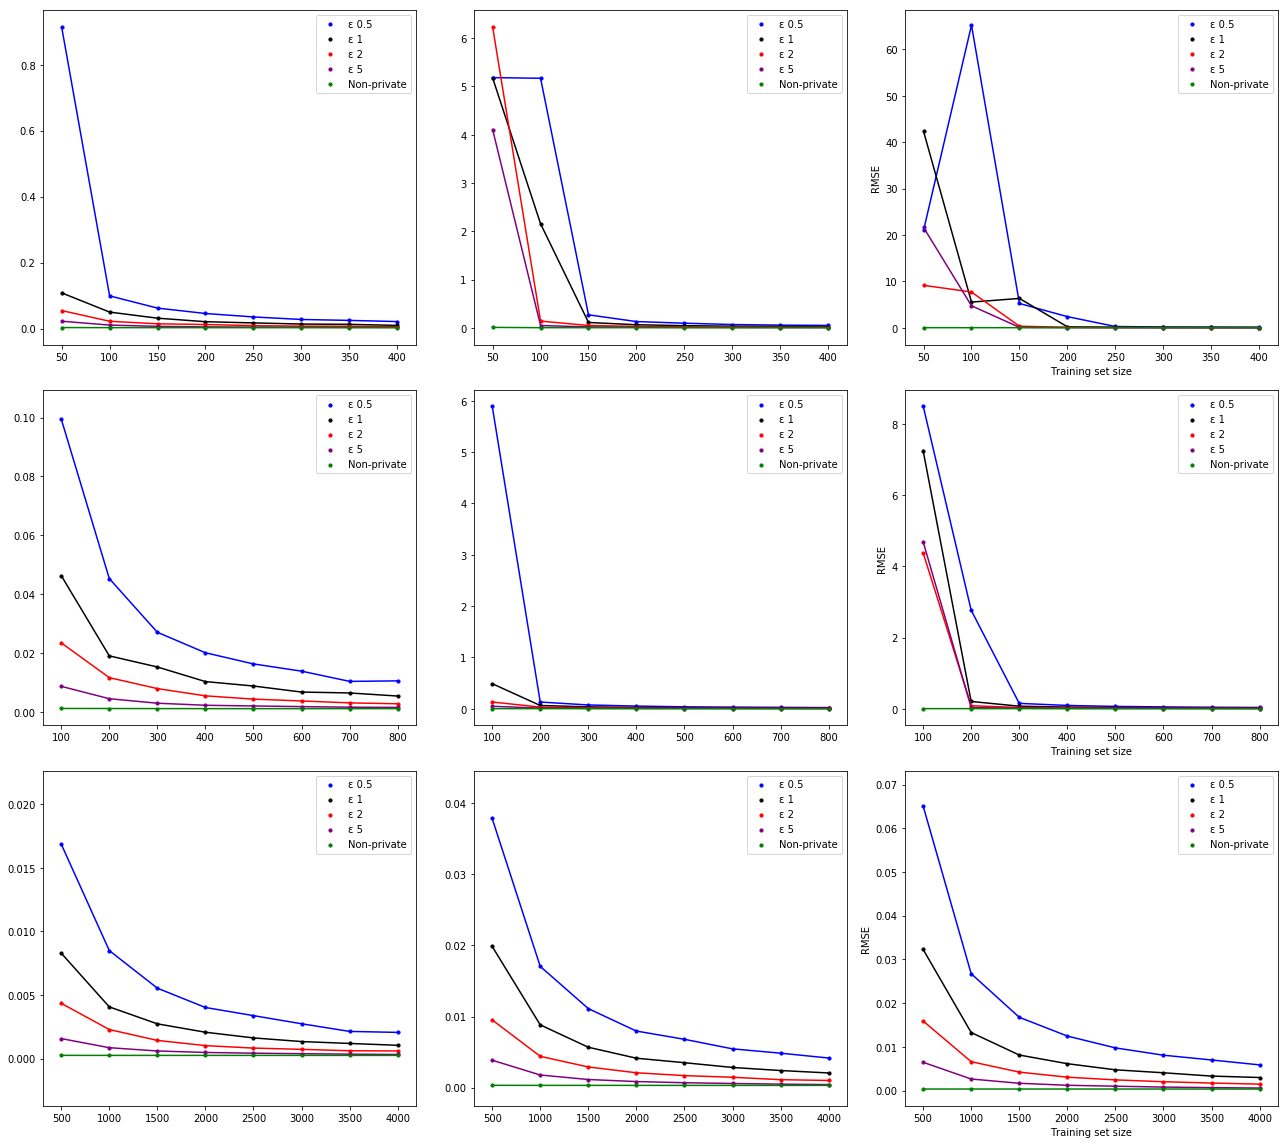

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
import math
from sklearn.preprocessing import normalize
import pylab

entries = [500, 1000, 5000]                     
features = [10, 50, 100]
eps = [0.5, 1, 2, 5] 
k = 5
colors = ["blue", "black", "red", "purple", "green"]

X,y = make_regression(n_samples = entries[len(entries)-1], n_features = features[len(features)-1], noise=0)
plotnum = 1

for i in range(len(entries)):
    for j in range(len(features)):
        plt.rcParams['figure.figsize'] = (18,16)
        plt.subplot(len(features),len(entries),plotnum)
        for e in range(len(eps)):
            entry = entries[i]
            feature = features[j]
            epsilon = eps[e]
            jump = math.floor(entry/10)
            
            ans = epsilon_plotter(X, y, k, feature, jump, entry, epsilon)

            plt.scatter(ans[0], ans[3], color=colors[e], s=10)
#             plt.errorbar(ans[0], ans[3], yerr=ans[4], color=colors[e], ecolor=colors[e], capsize=3)
            plt.errorbar(ans[0], ans[3], color=colors[e], ecolor=colors[e], capsize=3)
        
        plt.scatter(ans[0], ans[1], color=colors[4], s=10)
        plt.errorbar(ans[0], ans[1], color=colors[4], ecolor=colors[4], capsize=3)
        plt.gca().legend(('ε 0.5', 'ε 1', 'ε 2', 'ε 5', 'Non-private')) 
        plotnum = plotnum+1
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.tight_layout()
plt.show()
    
    

# Function to plot private and non-private k-fold RMSE vs trainset size curve

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
import math

def epsilon_plotter(totalX, totaly, k, features, jump, entries, epsilon):
    
    entries -= entries%k
    X = totalX[:entries, :features]
    y = totaly[:entries]
    d = features
    elems = math.floor((d+1)*(d)/2)

    uval = math.floor(entries/k)
    test_ratio = math.floor(uval/100)
    train_ratio = 1 - test_ratio
    n = math.floor(features/jump)
    m = math.floor((entries-uval)/jump)

    X = np.append(arr = np.ones((entries, 1)), values = X, axis=1)

    X = normalize(X, norm='l1')
#     y = y/max(abs(y))
    y = y/sum(abs(y))
#     print("L1 Norm")

#     X = normalize(X, norm='l2')
#     RMS = (sum(y**2))**0.5
#     y = y/RMS
#     print("L2 Norm")
    
    X_val = np.ones((m))
    
    RMSE_indi = np.ones((m, k))
    priv_RMSE_indi = np.ones((m, k))
    
    for l in range(k):

        X_test = X[uval*l:(uval*l)+uval, :]
        y_test = y[uval*l:(uval*l)+uval]
        
        X_without_XTest = X[:uval*l, :]
        X_without_XTest = np.append(arr=X_without_XTest, values=X[(uval*l)+uval:, :], axis=0)
        y_without_yTest = y[:uval*l]
        y_without_yTest = np.append(arr=y_without_yTest, values=y[(uval*l)+uval:])

        num = m
        
        for i in range(m):
            X_val[i] = (i+1)*jump
            X_train = X_without_XTest[:(i+1)*jump, :]
            y_train = y_without_yTest[:(i+1)*jump]

            xT = X_train.transpose();
            xTx = np.dot(xT, X_train)
            xTx_pinv = np.linalg.pinv(xTx)
            xTy = np.dot(xT, y_train)
            w = np.dot(xTx_pinv, xTy).reshape(features+1, 1)
            y_pred = np.dot(X_test, w)
                
            b1 = 1/(epsilon*elems)
            b2 = 1/(epsilon*d)
            priv_RMSE_per_lpl = np.zeros((10))

            # TO average out laplace noise
            for j in range(10):
                u_mirr = np.random.laplace(loc=0.0, scale=b1, size = math.floor((d+1)*(d+2)/2))

                pos = 0
                u = np.ones((d+1, d+1)) 
                for r in range(d+1):
                    for c in range(r, d+1):
                        u[c][r] = u_mirr[pos]
                        u[r][c] = u[c][r]
                        pos = pos+1
                v = np.random.laplace(loc=0.0, scale=b2, size=d+1)
            
                sTs = xTx + u
                sTt = xTy + v
                sTspinv = np.linalg.pinv(sTs)
                wi = np.dot(sTspinv, sTt) 
                T = np.dot(X_test,wi)
                priv_RMSE_per_lpl[j] = (np.mean(abs(T-y_test)**2)**0.5)

            RMSE_indi[i][l] = (np.mean(abs(y_pred-y_test)**2)**0.5)
            priv_RMSE_indi[i][l] = (np.mean(priv_RMSE_per_lpl))
        
    
    X_val = X_val.astype(int)

    total_RMSE = sum(RMSE_indi.transpose())/k
    priv_total_RMSE = sum(priv_RMSE_indi.transpose())/k

    RMSE_SD = np.zeros((RMSE_indi.shape[0]))
    priv_RMSE_SD = np.zeros((priv_RMSE_indi.shape[0]))
    for i in range(RMSE_indi.shape[0]):
        RMSE_SD[i] = (RMSE_indi[i].std())
        priv_RMSE_SD[i] = (priv_RMSE_indi[i].std())


    ans = np.ones((5, X_val.shape[0]))
    ans[0] = X_val
    ans[1] = total_RMSE
    ans[2] = RMSE_SD
    ans[3] = priv_total_RMSE
    ans[4] = priv_RMSE_SD
    
    return ans
